# Temperature Obs Figure

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cf_xarray
import cmocean as cm

In [2]:
# Import the data (names generalised to use for both comparisons)

deep_1 = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/pan01_control_obs_tob_deep_anomaly.nc', decode_times=False, chunks = 'auto')
deep_2 = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/pan005_control_obs_tob_deep_anomaly.nc', decode_times=False, chunks = 'auto')
deep_3 = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/access_control_obs_tob_deep_anomaly.nc', decode_times=False, chunks = 'auto')

shelf_1 = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/pan01_control_obs_tob_shelf_anomaly.nc', decode_times=False, chunks = 'auto')
shelf_2 = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/pan005_control_obs_tob_shelf_anomaly.nc', decode_times=False, chunks = 'auto')
shelf_3 = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/access_control_obs_tob_shelf_anomaly.nc', decode_times=False, chunks = 'auto')

In [3]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [4]:
# Land and contour data
depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
land_1 = xr.where(np.isnan(depth_1.rename('land_1')), 1, np.nan)

depth_2 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['deptho']
land_mask_2 = (0 * depth_2).fillna(1)
land_2 = xr.where(np.isnan(depth_2.rename('land_2')), 1, np.nan)

depth_3 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask_3 = (0 * depth_3).fillna(1)
land_3 = xr.where(np.isnan(depth_3.rename('land_3')), 1, np.nan)

shelf_contour_1, shelf_mask_1 = shelf_mask_isobath(depth_1, 'mom6_01')
shelf_contour_2, shelf_mask_2 = shelf_mask_isobath(depth_2, 'mom6_005')
shelf_contour_3, shelf_mask_3 = shelf_mask_isobath(depth_3, 'mom5')

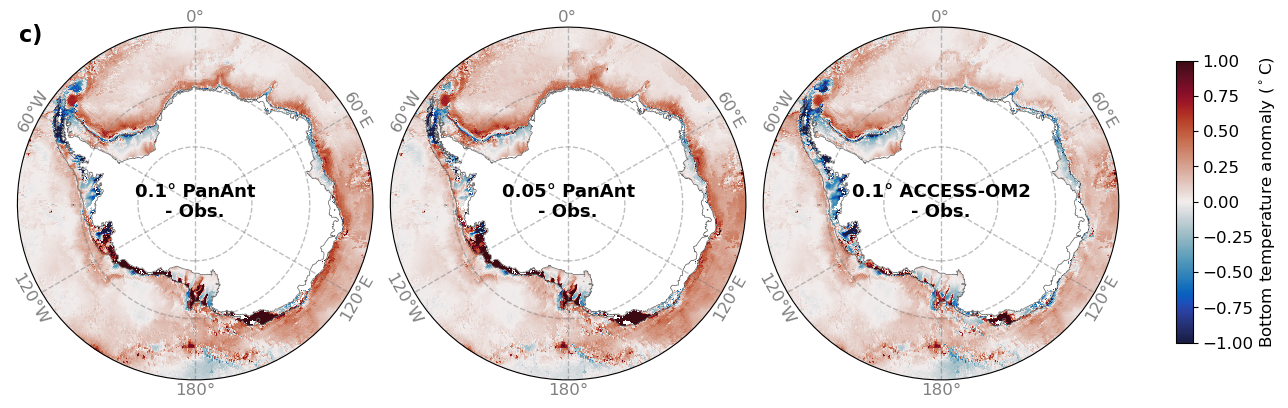

In [20]:
plt.rcParams['font.size'] = 16

# Projection
projection = ccrs.SouthPolarStereo()

# Figure with 2 subplots side by side
fig, axes = plt.subplots(
    nrows=1, ncols=3,
    subplot_kw={"projection": projection},
    figsize=(12.8, 5.6),
    constrained_layout=True
)

# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.495
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
deep_datasets = [deep_1, deep_2, deep_3] 
shelf_datasets = [shelf_1, shelf_2, shelf_3]
land_masks = [land_1, land_2, land_3]
land_contours = [land_mask_1, land_mask_2, land_mask_3]
shelf_masks = [shelf_mask_1, shelf_mask_2, shelf_mask_3]
titles = ["0.1° PanAnt\n- Obs.", "0.05° PanAnt\n- Obs.", "0.1° ACCESS-OM2\n- Obs."]

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-58, -58, -58, -57.5, -58, -58]

# Loop over subplots
for i, (ax, deep_data, shelf_data, land_m, land_contour, shelf_m, title) in enumerate(zip(
        axes, deep_datasets, shelf_datasets, land_masks, land_contours, shelf_masks, titles)):

    ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
    land_m.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

    # Coast line
    ax.contour(land_contour.cf['X'], land_contour.cf['Y'], land_contour,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf contour
    ax.contour(shelf_m.cf['X'], shelf_m.cf['Y'], shelf_m,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Gridlines (keep as in original plot)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
    gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

    # Manually rotate longitude labels
    for j, position in enumerate([0, 180, 60, -120, 120, -60]):
        ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=12,
                transform=ccrs.PlateCarree())

    # Plot dataset
    im = deep_data.plot(
        x="lon", y="lat",
        transform=ccrs.PlateCarree(),
        vmin=-1, vmax=1,
        extend="both",
        cmap=cm.cm.balance,
        add_colorbar=False,
        ax=ax,
    )

    # White shelf mask in between
    shelf_m.where(shelf_m == 1).plot(
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        cmap="gray",  # black=0, white=1
        vmin=0, vmax=1,
        ax=ax,  
    )
    
    shelf_data.plot(
        x="lon", y="lat",
        transform=ccrs.PlateCarree(),
        vmin=-1, vmax=1,
        extend="both",
        cmap=cm.cm.balance,
        add_colorbar=False,
        ax=ax,
    )

    # Set title
    ax.set_title("", fontsize=14, pad=25)
    ax.text(
        0.5, 0.5,
        title,
        transform=ax.transAxes,
        fontsize=13,
        weight="bold",
        ha="center", va="center",
    )

    if i == 0:  # label only the first subplot
        ax.text(0.01, 1, 'c)', transform=ax.transAxes,
                fontsize=16, fontweight='bold', va='top', ha='left', color='black')


# Smaller shared colorbar on the right
cbar = fig.colorbar(
    im, ax=axes, orientation="vertical",
    fraction=0.015,  # smaller width
    aspect=17,       # longer and thinner
    shrink=0.8, pad=0.05
)
cbar.set_label("Bottom temperature anomaly ($^\circ$C)", fontsize=12)
cbar.ax.tick_params(labelsize=12)  # tick font size

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/validation_tob_maps.png", dpi=300, bbox_inches='tight')

# Actual values (not anomalies)

In [21]:
# Import the data (names generalised to use for both comparisons)

data_1 = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/pan01_control_tob_last10yrave.nc', decode_times=False, chunks = 'auto')
data_2 = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/pan005_control_tob_last10yrave.nc', decode_times=False, chunks = 'auto')
data_3 = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/access_control_tob_last10yrave.nc', decode_times=False, chunks = 'auto')

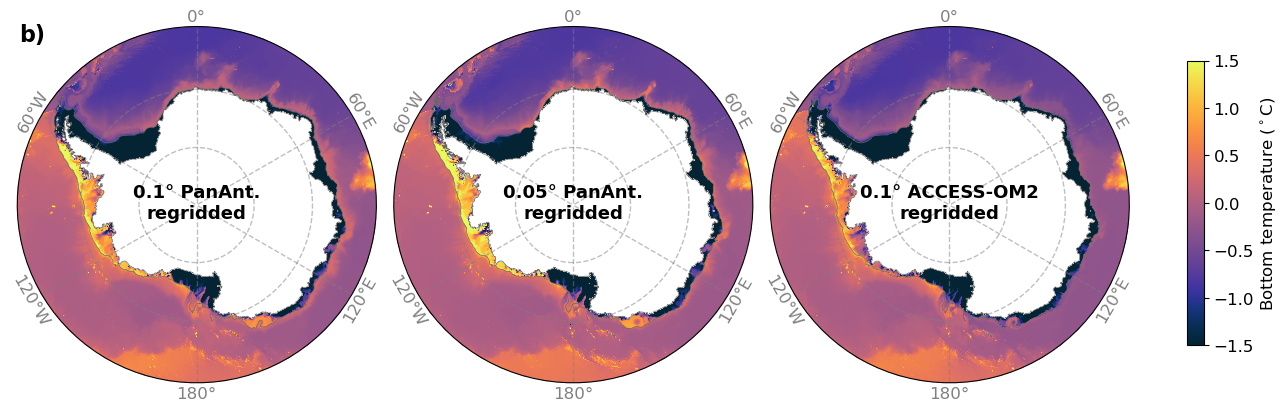

In [22]:
plt.rcParams['font.size'] = 16

# Projection
projection = ccrs.SouthPolarStereo()

# Figure with 2 subplots side by side
fig, axes = plt.subplots(
    nrows=1, ncols=3,
    subplot_kw={"projection": projection},
    figsize=(12.8, 5.6),
    constrained_layout=True
)

# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.495
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
datasets = [data_1, data_2, data_3-273.15] 
land_masks = [land_1, land_2, land_3]
land_contours = [land_mask_1, land_mask_2, land_mask_3]
shelf_masks = [shelf_mask_1, shelf_mask_2, shelf_mask_3]
titles = ["0.1° PanAnt.\nregridded", "0.05° PanAnt.\nregridded", "0.1° ACCESS-OM2\nregridded"]
xnames = ["xh","xh", "xt_ocean"]
ynames = ["yh","yh", "yt_ocean"]

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-58, -58, -58, -57.5, -58, -58]

# Loop over subplots
for i, (ax, data, land_m, land_contour, shelf_m, title,xname,yname) in enumerate(zip(
        axes, datasets, land_masks, land_contours, shelf_masks, titles,xnames,ynames)):

    ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
    land_m.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

    # Coast line
    ax.contour(land_contour.cf['X'], land_contour.cf['Y'], land_contour,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf contour
    ax.contour(shelf_m.cf['X'], shelf_m.cf['Y'], shelf_m,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Gridlines (keep as in original plot)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
    gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

    # Manually rotate longitude labels
    for j, position in enumerate([0, 180, 60, -120, 120, -60]):
        ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=12,
                transform=ccrs.PlateCarree())

    # Plot dataset
    im = data.plot(
        x=xname, y=yname,
        transform=ccrs.PlateCarree(),
        vmin=-1.5, vmax=1.5,
        extend="both",
        cmap=cm.cm.thermal,
        add_colorbar=False,
        ax=ax,
    )

    # Set title
    ax.set_title("", fontsize=14, pad=25)
    ax.text(
        0.5, 0.5,
        title,
        transform=ax.transAxes,
        fontsize=13,
        weight="bold",
        ha="center", va="center",
    )

    if i == 0:  # label only the first subplot
        ax.text(0.01, 1, 'b)', transform=ax.transAxes,
                fontsize=16, fontweight='bold', va='top', ha='left', color='black')


# Smaller shared colorbar on the right
cbar = fig.colorbar(
    im, ax=axes, orientation="vertical",
    fraction=0.015,  # smaller width
    aspect=17,       # longer and thinner
    shrink=0.8, pad=0.05
)
cbar.set_label("Bottom temperature ($^\circ$C)", fontsize=12)
cbar.ax.tick_params(labelsize=12)  # tick font size

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/validation_tob_permodel_maps.png", dpi=300, bbox_inches='tight')

# Salt and temp just obs

In [5]:
deep_salt = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/deep_WOA23_sob_last10yrave.nc', decode_times=False, chunks = 'auto')
deep_temp = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/deep_WOA23_tob_last10yrave.nc', decode_times=False, chunks = 'auto')
shelf_salt = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/shelf_schmidtko_sob_last10yrave.nc', decode_times=False, chunks = 'auto')
shelf_temp = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/shelf_schmidtko_tob_last10yrave.nc', decode_times=False, chunks = 'auto')

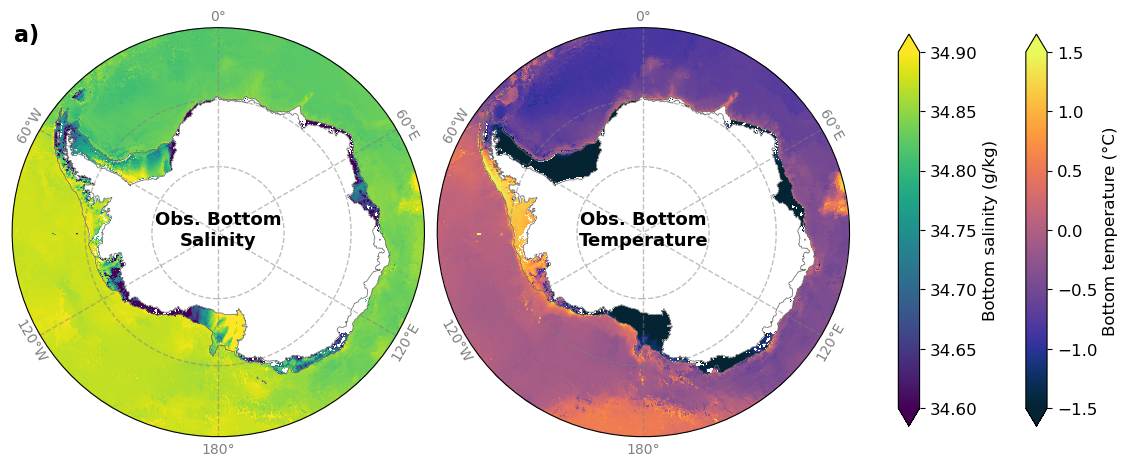

In [21]:
plt.rcParams['font.size'] = 16

# Projection
projection = ccrs.SouthPolarStereo()

# Figure with 2 subplots side by side
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    subplot_kw={"projection": projection},
    figsize=(8.5, 5.6),
    constrained_layout=True
)

# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.495
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
deep_datasets = [deep_salt, deep_temp] 
shelf_datasets = [shelf_salt, shelf_temp] 
land_masks = [land_1, land_1]
land_contours = [land_mask_1, land_mask_1]
shelf_masks = [shelf_mask_1, shelf_mask_1]
titles = ["Obs. Bottom\nSalinity", "Obs. Bottom\nTemperature"]
vmins = [34.6,-1.5]
vmaxs = [34.9,1.5]
cbars = [plt.get_cmap('viridis'),cm.cm.thermal]

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-58, -58, -58, -58, -58, -58]

ims = []

# Loop over subplots
for i, (ax, deep_data, shelf_data, land_m, land_contour, shelf_m, title,vmins,vmaxs,cbars) in enumerate(zip(
        axes, deep_datasets, shelf_datasets, land_masks, land_contours, shelf_masks, titles,vmins,vmaxs,cbars)):

    ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
    land_m.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

    # Coast line
    ax.contour(land_contour.cf['X'], land_contour.cf['Y'], land_contour,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf contour
    ax.contour(shelf_m.cf['X'], shelf_m.cf['Y'], shelf_m,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Gridlines (keep as in original plot)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
    gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

    # Manually rotate longitude labels
    for j, position in enumerate([0, 180, 60, -120, 120, -60]):
        ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=10,
                transform=ccrs.PlateCarree())

    # Plot dataset
    im = deep_data.plot(
        x="lon", y="lat",
        transform=ccrs.PlateCarree(),
        vmin=vmins, vmax=vmaxs,
        extend="both",
        cmap=cbars,
        add_colorbar=False,
        ax=ax,
    )

    ims.append(im)
    
    # White shelf mask in between
    shelf_m.where(shelf_m == 1).plot(
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        cmap="gray",  
        vmin=0, vmax=1,
        ax=ax,        
    )
    
    shelf_data.plot(
        x="lon", y="lat",
        transform=ccrs.PlateCarree(),
        vmin=vmins, vmax=vmaxs,
        extend="both",
        cmap=cbars,
        add_colorbar=False,
        ax=ax,
    )

    # Set title
    ax.set_title("", fontsize=14, pad=25)
    ax.text(
        0.5, 0.5,
        title,
        transform=ax.transAxes,
        fontsize=13,
        weight="bold",
        ha="center", va="center",
    )

    if i == 0:  # label only the first subplot
        ax.text(0.01, 1, 'a)', transform=ax.transAxes,
                fontsize=16, fontweight='bold', va='top', ha='left', color='black')


# Add manual colorbar axes (adjust positions if needed)
cbar_ax1 = fig.add_axes([1.2, 0.15, 0.025, 0.7])   # left of the pair
cbar_ax2 = fig.add_axes([1.05, 0.15, 0.025, 0.7])  # right of the pair

# Salinity colorbar (assuming right subplot = salinity)
cb1 = fig.colorbar(
    ims[1], cax=cbar_ax1, orientation='vertical', extend='both', fraction=0.015,  # smaller width
    shrink=0.8, pad=0.05
)
cb1.set_label("Bottom temperature (°C)", fontsize=12)
cb1.ax.tick_params(labelsize=12)

# Temperature colorbar (assuming left subplot = temperature)
cb2 = fig.colorbar(
    ims[0], cax=cbar_ax2, orientation='vertical', extend='both',fraction=0.015,  # smaller width
    shrink=0.8, pad=0.05
)
cb2.set_label("Bottom salinity (g/kg)", fontsize=12)
cb2.ax.tick_params(labelsize=12)


plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/validation_obs_tempsalt_maps.png", dpi=300, bbox_inches='tight')

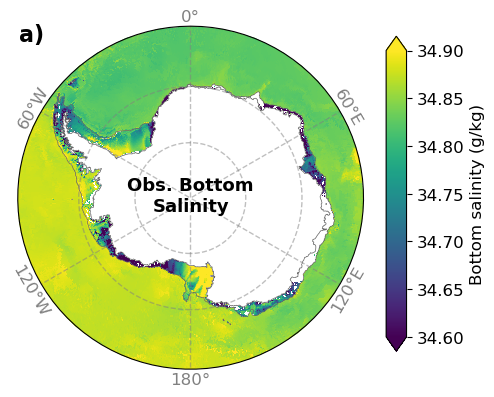

In [19]:
plt.rcParams['font.size'] = 16

# Projection
projection = ccrs.SouthPolarStereo()

fig, ax = plt.subplots(
    nrows=1, ncols=1,
    subplot_kw={"projection": projection},
    figsize=(6.8,4.5),
    constrained_layout=False
)


# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.495
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
vmins = 34.6
vmaxs = 34.9

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-58, -58, -58, -57.5, -58, -58]

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
land_1.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

# Coast line
ax.contour(land_mask_1.cf['X'], land_mask_1.cf['Y'], land_mask_1,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

# Shelf contour
ax.contour(shelf_mask_1.cf['X'], shelf_mask_1.cf['Y'], shelf_mask_1,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

# Gridlines (keep as in original plot)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

# Manually rotate longitude labels
for j, position in enumerate([0, 180, 60, -120, 120, -60]):
    ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=12,
                transform=ccrs.PlateCarree())

# Plot dataset
im = deep_salt.plot(
        x="lon", y="lat",
        transform=ccrs.PlateCarree(),
        vmin=vmins, vmax=vmaxs,
        extend="both",
        cmap=plt.get_cmap('viridis'),
        add_colorbar=False,
        ax=ax,
    )
    
# White shelf mask in between
shelf_mask_1.where(shelf_mask_1 == 1).plot(
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        cmap="gray",  
        vmin=0, vmax=1,
        ax=ax,        
    )
    
shelf_salt.plot(
        x="lon", y="lat",
        transform=ccrs.PlateCarree(),
        vmin=vmins, vmax=vmaxs,
        extend="both",
        cmap=plt.get_cmap('viridis'),
        add_colorbar=False,
        ax=ax,
    )

# Set title
ax.set_title("", fontsize=14, pad=25)
ax.text(
        0.5, 0.5,
        "Obs. Bottom\nSalinity",
        transform=ax.transAxes,
        fontsize=13,
        weight="bold",
        ha="center", va="center",
    )

ax.text(0.01, 1, 'a)', transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='left', color='black')

# Colorbar
cbar_ax2 = fig.add_axes([0.8, 0.15, 0.03, 0.7])  # move inside figure bounds
cb2 = fig.colorbar(im, cax=cbar_ax2, orientation='vertical', extend='both')
cb2.set_label("Bottom salinity (g/kg)", fontsize=12)
cb2.ax.tick_params(labelsize=12)


plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/validation_obs_salt_map.png", dpi=300, bbox_inches='tight')

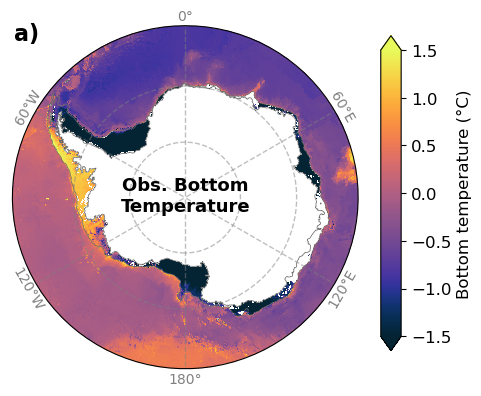

In [17]:
plt.rcParams['font.size'] = 16

# Projection
projection = ccrs.SouthPolarStereo()

fig, ax = plt.subplots(
    nrows=1, ncols=1,
    subplot_kw={"projection": projection},
    figsize=(6.8,4.5),
    constrained_layout=False
)


# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.495
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
vmins = -1.5
vmaxs = 1.5

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-58, -58, -58, -58, -58, -58]

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
land_1.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

# Coast line
ax.contour(land_mask_1.cf['X'], land_mask_1.cf['Y'], land_mask_1,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

# Shelf contour
ax.contour(shelf_mask_1.cf['X'], shelf_mask_1.cf['Y'], shelf_mask_1,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

# Gridlines (keep as in original plot)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

# Manually rotate longitude labels
for j, position in enumerate([0, 180, 60, -120, 120, -60]):
    ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=10,
                transform=ccrs.PlateCarree())

# Plot dataset
im = deep_temp.plot(
        x="lon", y="lat",
        transform=ccrs.PlateCarree(),
        vmin=vmins, vmax=vmaxs,
        extend="both",
        cmap=cm.cm.thermal,
        add_colorbar=False,
        ax=ax,
    )
    
# White shelf mask in between
shelf_mask_1.where(shelf_mask_1 == 1).plot(
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        cmap="gray",  
        vmin=0, vmax=1,
        ax=ax,        
    )
    
shelf_temp.plot(
        x="lon", y="lat",
        transform=ccrs.PlateCarree(),
        vmin=vmins, vmax=vmaxs,
        extend="both",
        cmap=cm.cm.thermal,
        add_colorbar=False,
        ax=ax,
    )

# Set title
ax.set_title("", fontsize=14, pad=25)
ax.text(
        0.5, 0.5,
        "Obs. Bottom\nTemperature",
        transform=ax.transAxes,
        fontsize=13,
        weight="bold",
        ha="center", va="center",
    )

ax.text(0.01, 1, 'a)', transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='left', color='black')

# Colorbar
cbar_ax2 = fig.add_axes([0.8, 0.15, 0.03, 0.7])  # move inside figure bounds
cb2 = fig.colorbar(im, cax=cbar_ax2, orientation='vertical', extend='both')
cb2.set_label("Bottom temperature (°C)", fontsize=12)
cb2.ax.tick_params(labelsize=12)


plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/validation_obs_temp_map.png", dpi=300, bbox_inches='tight')